화이트 박스처럼 자세한 내용을 몰라도 잘 작동하는 것을 체험해봤지만,

어떻게 작동하는 지 잘 알고 있느면 세부적으로 성능을 향상시킬 수 있음

##4.1 선형회귀

선형회귀모델에서 MSE를 최소화하는 방식을 찾는 과정에서

해석학적인 방법을 사용할 수 있음, normal equation, 정규방정식



In [1]:
import numpy as np

np.random.seed(42)
m = 100
X = 2*np.random.rand(m,1)
y = 4 + 3*X + np.random.rand(m,1)

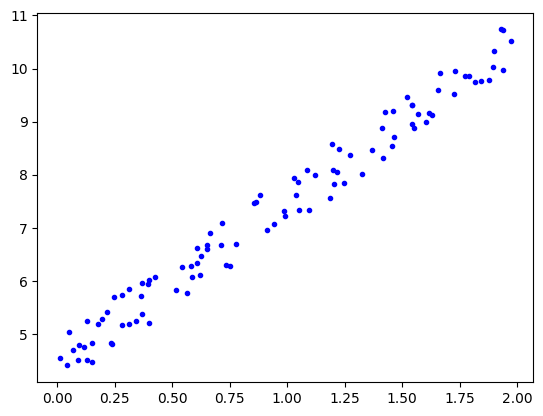

In [2]:
import matplotlib.pyplot as plt

plt.plot(X,y,'b.')
plt.show()

정규방정식을 이용해 추정해보자

In [3]:
from sklearn.preprocessing import add_dummy_feature

X_b = add_dummy_feature(X)
theta_best = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y

@ 연산자는 행렬 곱을 의미한다

우리가 임의로 만들어낸 이 데이터의 식은

y = 4 + 3x + gaussian noise 이었다

정규방정식으로 계산하여 비교해보자

In [4]:
print(theta_best)

[[4.51359766]
 [2.98323418]]


얼추 비슷하게 유추해내었다.

잡음 때문에 정확히 예측해내진 못하였다.

데이터 셋이 작고 잡음이 많을수록 정확한 값을 얻기가 어려워진다.

In [5]:
X_new = np.array([[0],[2]])
X_new_b = add_dummy_feature(X_new)
y_pred = X_new_b @ theta_best
print(y_pred)

[[ 4.51359766]
 [10.48006601]]


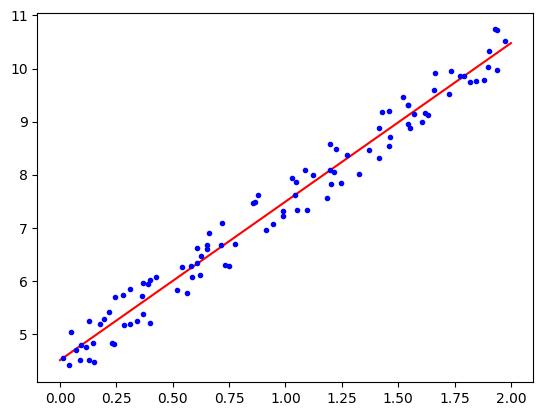

In [6]:
import matplotlib.pyplot  as plt

plt.plot(X_new, y_pred, "r-")
plt.plot(X, y, "b.")
plt.show()

In [7]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X,y)
print(lin_reg.intercept_, lin_reg.coef_)
print(lin_reg.predict(X_new))

[4.51359766] [[2.98323418]]
[[ 4.51359766]
 [10.48006601]]


In [8]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
print(theta_best_svd)

[[4.51359766]
 [2.98323418]]


#4.2 경사하강법

##4.2.1 배치 경사 하강법

In [9]:
eta = 0.1
n_epochs = 1000
m = len(X_b)

np.random.seed(42)
theta = np.random.randn(2,1)

for epoch in range(n_epochs):
  gradients = 2/m * X_b.T @ (X_b @ theta - y)
  theta = theta - eta * gradients

print(theta)

[[4.51359766]
 [2.98323418]]


##4.2.2 확률적 경사 하강법

In [10]:
n_epochs = 50
t0, t1 = 5,50

def learning_schedule(t):
  return t0 / (t+t1)

np.random.seed(42)
theta = np.random.randn(2,1)

for epoch in range(n_epochs):
  for iteration in range(m):
    random_index = np.random.randint(m)
    xi = X_b[random_index:random_index+1]
    yi = y[random_index:random_index+1]
    gradients = 2 * xi.T @ (xi @ theta - yi)
    eta = learning_schedule(epoch * m + iteration)
    theta = theta - eta * gradients

print(theta)

[[4.51548062]
 [2.9775157 ]]


사이킷런으로 확률적 경사 하강법 구현하기

In [11]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000,
                       tol=1e-5,
                       penalty=None,
                       eta0=0.01,
                       n_iter_no_change=100,
                       random_state=42)

sgd_reg.fit(X,y.ravel())

print(sgd_reg.intercept_, sgd_reg.coef_)

[4.50316965] [2.99156535]


#4.3 다항회귀

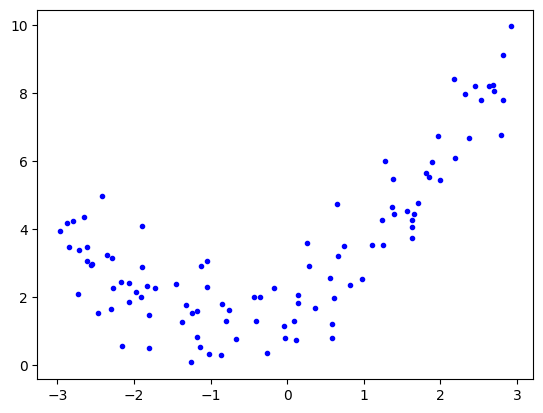

In [12]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m,1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m,1)

import matplotlib.pyplot as plt

plt.plot(X,y,'b.')
plt.show()

다항식의 피쳐로 변환해주는 라이브러리

In [13]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

print(X[0])
print(X_poly[0])

[-0.75275929]
[-0.75275929  0.56664654]


In [14]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
print(lin_reg.intercept_, lin_reg.coef_)

[1.78134581] [[0.93366893 0.56456263]]


#4.4 학습곡선

과적합 방지, 교차 검증 외에 학습 곡선을 확인하는 방법

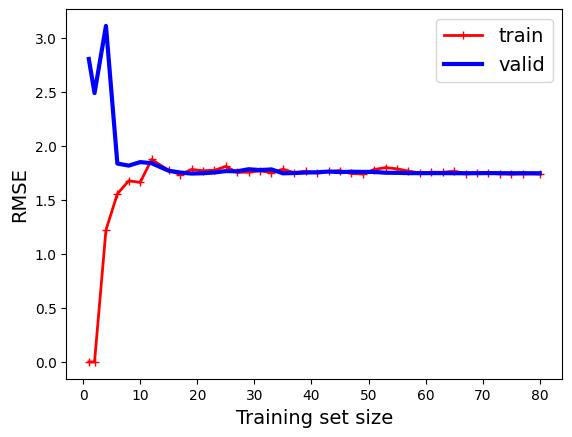

In [15]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(LinearRegression(),
                                                         X, y,
                                                         train_sizes=np.linspace(0.01,1.0,40),
                                                         cv=5,
                                                         scoring='neg_root_mean_squared_error')
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.plot(train_sizes, train_errors, 'r-+', linewidth=2, label='train')
plt.plot(train_sizes, valid_errors, 'b-', linewidth=3, label='valid')
plt.legend(loc='upper right', fontsize=14)
plt.xlabel('Training set size', fontsize=14)
plt.ylabel('RMSE', fontsize=14)
plt.show()

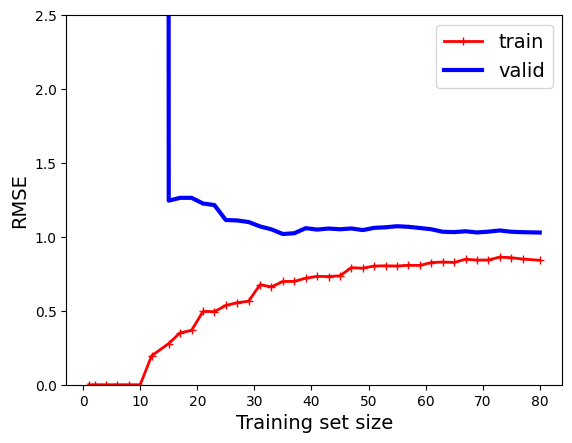

In [16]:
from sklearn.pipeline import make_pipeline

polynomial_regression = make_pipeline(PolynomialFeatures(degree=10, include_bias=False),
                                      LinearRegression())

train_sizes, train_scores, valid_scores = learning_curve(polynomial_regression,
                                                        X, y,
                                                        train_sizes=np.linspace(0.01,1.0,40),
                                                        cv=5,
                                                        scoring='neg_root_mean_squared_error')

train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.plot(train_sizes, train_errors, 'r-+', linewidth=2, label='train')
plt.plot(train_sizes, valid_errors, 'b-', linewidth=3, label='valid')
plt.legend(loc='upper right', fontsize=14)
plt.xlabel('Training set size', fontsize=14)
plt.ylabel('RMSE', fontsize=14)
plt.ylim(0,2.5)
plt.show()

#4.5 규제가 있는 선형모델

##4.5.1 릿지 회귀

릿지 - 정규방정식

In [17]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=0.1, solver='cholesky')
ridge_reg.fit(X,y)
print(ridge_reg.predict([[1.5]]))

[4.82899748]


릿지 - SGD

In [18]:
sgd_reg = SGDRegressor(penalty='l2',
                       alpha=0.1/m,
                       tol=None,
                       max_iter=1000,
                       eta0=0.01,
                       random_state=42)
sgd_reg.fit(X,y.ravel())
print(sgd_reg.predict([[1.5]]))

[4.82830117]


##4.5.2 라쏘 회귀

In [19]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X,y)
print(lasso_reg.predict([[1.5]]))

[4.77621741]


##4.5.3 엘라스틱넷 회귀

In [20]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X,y)
print(elastic_net.predict([[1.5]]))

[4.78114505]


##4.5.4 조기 종료

In [21]:
from copy import deepcopy
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

X_train, y_train, X_valid, y_valid = X[:40], y[:40], X[40:], y[40:]

preprocessing = make_pipeline(PolynomialFeatures(degree=90,include_bias=False),
                               StandardScaler())
X_train_prep = preprocessing.fit_transform(X_train)
X_valid_prep = preprocessing.transform(X_valid)
sgd_reg = SGDRegressor(penalty=None,
                       eta0=0.002,
                       random_state=42)
n_epochs = 500
best_valid_rmse = float('inf')

for epoch in range(n_epochs):
  sgd_reg.partial_fit(X_train_prep, y_train)
  y_valid_predict = sgd_reg.predict(X_valid_prep)
  val_error = mean_squared_error(y_valid, y_valid_predict)

  if val_error < best_valid_rmse:
    best_valid_rmse = val_error
    best_model = deepcopy(sgd_reg)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

#4.6 로지스틱 회귀

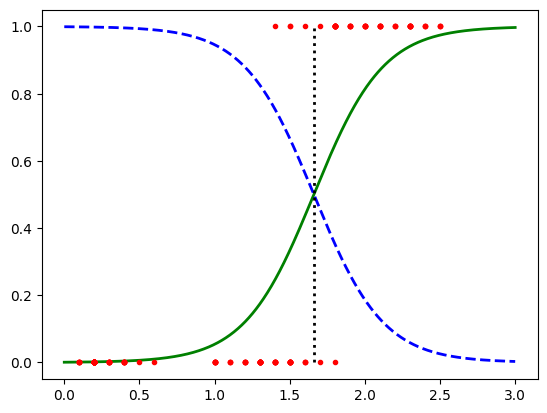

In [22]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = iris.data[["petal width (cm)"]].values
y = iris.target_names[iris.target] == 'virginica'
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

log_reg = LogisticRegression(random_state=42)
log_reg.fit(X,y)

X_new = np.linspace(0,3,1000).reshape(-1,1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:,1] >= 0.5][0,0]

plt.plot(X_new, y_proba[:,1], 'g-', linewidth=2, label='virginica')
plt.plot(X_new, y_proba[:,0], 'b--', linewidth=2, label='non-virginica')
plt.plot([decision_boundary, decision_boundary], [0,1], 'k:', linewidth=2)
plt.plot(X,y,'r.')
plt.show()

#4.6.4 소프트맥스 회귀

In [23]:
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

softmax_reg = LogisticRegression(C=30, random_state=42)
softmax_reg.fit(X_train, y_train)

LogisticRegression(C=30, random_state=42)